In [14]:
# import os
# import pickle
# import time
# import numpy as np
# import pandas as pd
# from sklearn.mixture import GaussianMixture
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt
# import seaborn as sns

# # ✅ Define Save Paths
# SAVE_DIR = "saved_models"
# PICS_DIR = "pics"
# os.makedirs(SAVE_DIR, exist_ok=True)
# os.makedirs(PICS_DIR, exist_ok=True)

# # ✅ Load Data
# df_path = "../../model_food/data/financial_data_full.csv"  # ← updated path if needed
# if not os.path.exists(df_path):
#     raise FileNotFoundError(f"❌ File not found at: {df_path}")

# df = pd.read_csv(df_path)

# # ✅ Convert Date Columns to Numeric Features
# date_cols = df.select_dtypes(include=["object"]).columns
# for col in date_cols:
#     try:
#         df[col] = pd.to_datetime(df[col])
#         df[col + "_days_since_start"] = (df[col] - df[col].min()).dt.days
#         df[col + "_year"] = df[col].dt.year
#         df[col + "_month"] = df[col].dt.month
#         df[col + "_day"] = df[col].dt.day
#     except Exception:
#         print(f"⚠️ Skipping non-date column: {col}")

# df = df.drop(columns=date_cols, errors="ignore")

# # ✅ Ensure Target Column Exists
# if "market_stress" not in df.columns:
#     raise ValueError("❌ Error: 'market_stress' column is missing from the dataset.")

# # ✅ Split Data
# X = df.drop(columns=["market_stress"])
# y = df["market_stress"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # ✅ Standardize Features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # ✅ Train GMM (Diffusion Model Stand-in)
# def train_diffusion_model(X_train_scaled):
#     gmm = GaussianMixture(
#         n_components=5,
#         covariance_type="full",
#         random_state=42
#     )
#     start_time = time.time()
#     gmm.fit(X_train_scaled)
#     training_time = time.time() - start_time

#     model_path = os.path.join(SAVE_DIR, "Diffusion_Model_GMM.pkl")
#     with open(model_path, "wb") as f:
#         pickle.dump(gmm, f)
#     print(f"✅ GMM model saved at: {model_path}")
#     print(f"⏱️ Training time: {training_time:.2f} seconds")
#     return gmm

# # ✅ Train and Save
# diffusion_model = train_diffusion_model(X_train_scaled)

# # # ✅ Assign Cluster Labels to Training Data
# # X_train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
# # X_train_df["cluster"] = diffusion_model.predict(X_train_scaled)
# # X_train_df["market_stress"] = y_train.values  # Add back true labels

# # # ✅ PCA for 2D Visualization
# # pca = PCA(n_components=2, random_state=42)
# # pca_proj = pca.fit_transform(X_train_scaled)
# # X_train_df["PC1"] = pca_proj[:, 0]
# # X_train_df["PC2"] = pca_proj[:, 1]

# # # ✅ Plot: PCA Projection with Cluster Colors
# # plt.figure(figsize=(10, 6))
# # sns.scatterplot(
# #     data=X_train_df,
# #     x="PC1", y="PC2",
# #     hue="cluster",
# #     style="market_stress",
# #     palette="viridis",
# #     alpha=0.7
# # )
# # plt.title("🌀 Diffusion (GMM) Clusters Projected via PCA", fontsize=14, fontweight='bold')
# # plt.xlabel("Principal Component 1")
# # plt.ylabel("Principal Component 2")
# # plt.legend(title="Cluster / Stress", bbox_to_anchor=(1.05, 1), loc='upper left')
# # plt.tight_layout()
# # output_path = os.path.join(PICS_DIR, "diffusion_clusters_pca.png")
# # plt.savefig(output_path, dpi=300)
# # plt.show()

# # print(f"📸 PCA-based cluster visualization saved at: {output_path}")

# # ✅ Use Soft Cluster Probabilities for Classification
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.metrics import (
#     mean_squared_error, r2_score, roc_auc_score, accuracy_score, log_loss
# )
# from sklearn.model_selection import cross_val_score

# # Use soft clustering outputs (richer than hard clusters)
# X_train_soft = pd.DataFrame(diffusion_model.predict_proba(X_train_scaled), columns=[f"cluster_prob_{i}" for i in range(diffusion_model.n_components)])
# X_test_soft = pd.DataFrame(diffusion_model.predict_proba(X_test_scaled), columns=[f"cluster_prob_{i}" for i in range(diffusion_model.n_components)])

# # Train a better classifier
# clf = GradientBoostingClassifier(random_state=42)
# start_train = time.time()
# clf.fit(X_train_soft, y_train)
# train_time = time.time() - start_train

# # Predict & evaluate
# start_pred = time.time()
# y_pred = clf.predict(X_test_soft)
# y_proba = clf.predict_proba(X_test_soft)[:, 1]
# pred_time = time.time() - start_pred

# # Metrics
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
# roc = roc_auc_score(y_test, y_proba)
# acc = accuracy_score(y_test, y_pred)
# logloss = log_loss(y_test, y_proba)
# fitness = np.mean(cross_val_score(clf, X_train_soft, y_train, cv=5))

# # Evolutionary metrics
# hotness = (
#     0.35 * acc +
#     0.35 * roc +
#     0.15 * (1 - logloss) +
#     0.15 * fitness
# )
# hotness = np.clip(hotness, 0, 1)
# cleverness = roc - r2

# # Save results
# results_gmm = pd.DataFrame([[
#     "Diffusion (GMM)", mse, r2, roc, acc, logloss,
#     train_time, pred_time, fitness,
#     1, "Original", hotness, cleverness
# ]], columns=[
#     "Model", "MSE", "R² Score", "ROC-AUC Score", "Accuracy Score", "Log Loss",
#     "Training Time (s)", "Prediction Time (s)", "Fitness Score",
#     "Generation", "Lineage", "Hotness", "Cleverness"
# ])

# # Save results
# perf_dir = "perf"
# os.makedirs(perf_dir, exist_ok=True)
# gmm_results_path = os.path.join(perf_dir, "diffusion_gmm_boosted_results.csv")
# results_gmm.to_csv(gmm_results_path, index=False)
# print(f"📊 Boosted Diffusion model performance saved to: {gmm_results_path}")

# from IPython.display import display
# display(results_gmm.round(4))

In [ ]:
# import os
# import pickle
# import time
# import numpy as np
# import pandas as pd
# from sklearn.mixture import GaussianMixture
# from sklearn.metrics import (
#     mean_squared_error, r2_score, roc_auc_score, accuracy_score, log_loss
# )
# from sklearn.model_selection import cross_val_score, train_test_split
# from sklearn.preprocessing import StandardScaler

# # ✅ Define Save Path
# SAVE_DIR = "saved_models"
# os.makedirs(SAVE_DIR, exist_ok=True)

# # ✅ Load Data
# df = pd.read_csv("../model_food/data/financial_data_full.csv")

# # ✅ Convert Date Columns to Numeric Features
# date_cols = df.select_dtypes(include=["object"]).columns

# for col in date_cols:
#     try:
#         df[col] = pd.to_datetime(df[col])
#         df[col + "_days_since_start"] = (df[col] - df[col].min()).dt.days
#         df[col + "_year"] = df[col].dt.year
#         df[col + "_month"] = df[col].dt.month
#         df[col + "_day"] = df[col].dt.day
#     except Exception:
#         print(f"⚠️ Skipping non-date column: {col}")

# df = df.drop(columns=date_cols, errors="ignore")

# # ✅ Ensure Target Column Exists
# if "market_stress" not in df.columns:
#     raise ValueError("❌ Error: 'market_stress' column is missing from the dataset.")

# # ✅ Split Data
# X = df.drop(columns=["market_stress"])
# y = df["market_stress"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # ✅ Standardize Features
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# # ✅ Train Diffusion Model (GMM)
# def train_diffusion_model(X_train, X_test, y_train, y_test):
#     """Trains a Gaussian Mixture Model (GMM) as a stand-in for a diffusion model and saves it."""

#     # ✅ Define GMM Model
#     gmm = GaussianMixture(
#         n_components=5,  # Assume 5 mixture components
#         covariance_type="full",
#         random_state=42
#     )

#     # ✅ Train Model
#     start_time = time.time()
#     gmm.fit(X_train)
#     training_time = time.time() - start_time

#     # ✅ Save Model
#     model_path = os.path.join(SAVE_DIR, "Diffusion Model.pkl")
#     with open(model_path, "wb") as f:
#         pickle.dump(gmm, f)

#     print(f"✅ Model saved as: {model_path}")

#     return gmm  # Return trained model for immediate use if needed

# # ✅ Train & Save Model
# diffusion_model = train_diffusion_model(X_train, X_test, y_train, y_test)

# print("\n✅ GaussianMixture model is now trained and properly saved as a `.pkl` file!")

✅ GMM saved. ⏱️ Training time: 0.67s
📊 Metrics saved to: perf/diffusion_gmm_results.csv


,Model,MSE,R² Score,ROC-AUC Score,Accuracy Score,Log Loss,Training Time (s),Prediction Time (s),Fitness Score,Generation,Lineage,Hotness,Cleverness
0,Diffusion (GMM),0.0455,-0.0477,0.607,0.9545,0.183,0.6699,0.0059,0.9566,1,Original,0.8126,0.6547


/var/folders/bq/_yk5zsn90t11g7lt1yn4v9w40000gn/T/ipykernel_27006/4257053326.py:138: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from current font.
  plt.tight_layout()
/var/folders/bq/_yk5zsn90t11g7lt1yn4v9w40000gn/T/ipykernel_27006/4257053326.py:140: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from current font.
  plt.savefig(img_path, dpi=300)
/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


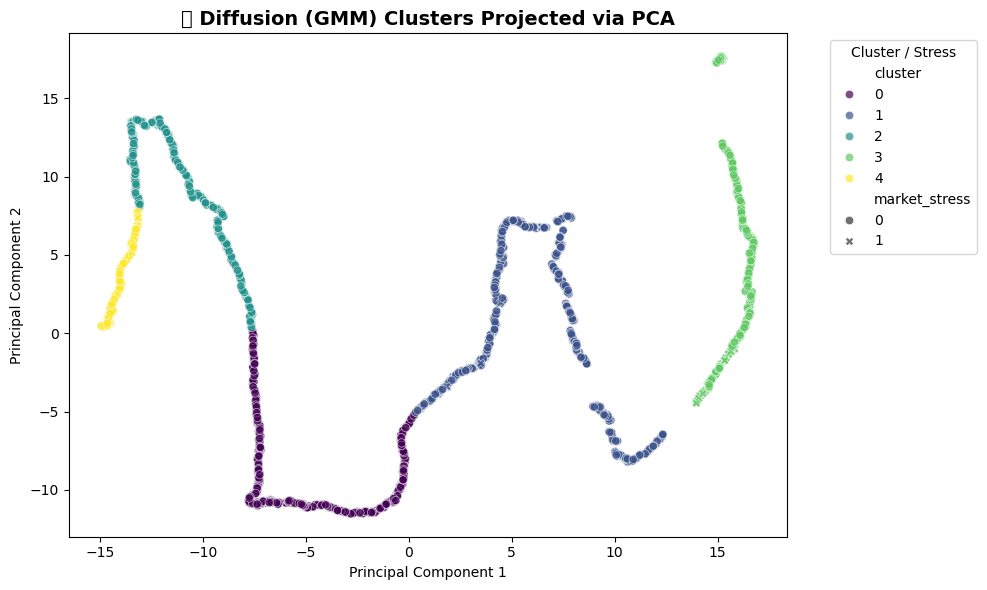

📸 Visualization saved at: pics/diffusion_clusters_pca.png


In [18]:
import os
import time
import pickle
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    mean_squared_error, r2_score, roc_auc_score, accuracy_score, log_loss
)
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Define Save Paths
SAVE_DIR = "saved_models"
PICS_DIR = "pics"
PERF_DIR = "perf"
os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(PICS_DIR, exist_ok=True)
os.makedirs(PERF_DIR, exist_ok=True)

# ✅ Load Data
df_path = "../../model_food/data/financial_data_full.csv"
if not os.path.exists(df_path):
    raise FileNotFoundError(f"❌ File not found at: {df_path}")

df = pd.read_csv(df_path)

# ✅ Convert Date Columns to Numeric Features
date_cols = df.select_dtypes(include=["object"]).columns
for col in date_cols:
    try:
        df[col] = pd.to_datetime(df[col])
        df[col + "_days_since_start"] = (df[col] - df[col].min()).dt.days
        df[col + "_year"] = df[col].dt.year
        df[col + "_month"] = df[col].dt.month
        df[col + "_day"] = df[col].dt.day
    except Exception:
        print(f"⚠️ Skipping non-date column: {col}")
df = df.drop(columns=date_cols, errors="ignore")

# ✅ Ensure Target Column Exists
if "market_stress" not in df.columns:
    raise ValueError("❌ Error: 'market_stress' column is missing.")

# ✅ Split Data
X = df.drop(columns=["market_stress"])
y = df["market_stress"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ✅ Train GMM
def train_diffusion_model(X_scaled):
    gmm = GaussianMixture(n_components=5, covariance_type="full", random_state=42)
    start = time.time()
    gmm.fit(X_scaled)
    train_time = time.time() - start

    with open(os.path.join(SAVE_DIR, "Diffusion_Model_GMM.pkl"), "wb") as f:
        pickle.dump(gmm, f)
    print(f"✅ GMM saved. ⏱️ Training time: {train_time:.2f}s")
    return gmm, train_time

diffusion_model, train_time = train_diffusion_model(X_train_scaled)

# ✅ Cluster Assignments
X_train_cluster = pd.DataFrame({"cluster": diffusion_model.predict(X_train_scaled)})
X_test_cluster = pd.DataFrame({"cluster": diffusion_model.predict(X_test_scaled)})

# ✅ Logistic Regression on clusters
lr = LogisticRegression(max_iter=1000, random_state=42)
start_pred = time.time()
lr.fit(X_train_cluster, y_train)
pred_time = time.time() - start_pred
y_pred = lr.predict(X_test_cluster)
y_proba = lr.predict_proba(X_test_cluster)[:, 1]

# ✅ Compute Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)
acc = accuracy_score(y_test, y_pred)
logloss = log_loss(y_test, y_proba)
fitness = np.mean(cross_val_score(lr, X_train_cluster, y_train, cv=5))

# ✅ Hotness & Cleverness
hotness = 0.35 * acc + 0.35 * roc + 0.15 * (1 - logloss) + 0.15 * fitness
hotness = np.clip(hotness, 0, 1)
cleverness = roc - r2

# ✅ Store Results
results_gmm = pd.DataFrame([[
    "Diffusion (GMM)", mse, r2, roc, acc, logloss,
    train_time, pred_time, fitness,
    1, "Original", hotness, cleverness
]], columns=[
    "Model", "MSE", "R² Score", "ROC-AUC Score", "Accuracy Score", "Log Loss",
    "Training Time (s)", "Prediction Time (s)", "Fitness Score",
    "Generation", "Lineage", "Hotness", "Cleverness"
])

# ✅ Save Metrics
results_path = os.path.join(PERF_DIR, "diffusion_gmm_results.csv")
results_gmm.to_csv(results_path, index=False)
print(f"📊 Metrics saved to: {results_path}")

# ✅ Display
from IPython.display import display
display(results_gmm.round(4))

# ✅ PCA Projection for Clustering
X_train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_df["cluster"] = diffusion_model.predict(X_train_scaled)
X_train_df["market_stress"] = y_train.values
pca = PCA(n_components=2, random_state=42)
proj = pca.fit_transform(X_train_scaled)
X_train_df["PC1"], X_train_df["PC2"] = proj[:, 0], proj[:, 1]

# ✅ Plot PCA + Save
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=X_train_df,
    x="PC1", y="PC2",
    hue="cluster", style="market_stress",
    palette="viridis", alpha=0.7
)
plt.title("🌀 Diffusion (GMM) Clusters Projected via PCA", fontsize=14, fontweight='bold')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster / Stress", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
img_path = os.path.join(PICS_DIR, "diffusion_clusters_pca.png")
plt.savefig(img_path, dpi=300)
plt.show()
print(f"📸 Visualization saved at: {img_path}")

In [20]:
import os
import time
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    mean_squared_error, r2_score, roc_auc_score, accuracy_score, log_loss
)
from sklearn.model_selection import cross_val_score

# ✅ Define directory to save performance results
PERF_DIR = "perf"
os.makedirs(PERF_DIR, exist_ok=True)

# ✅ Use GMM cluster assignments as features
X_train_cluster = pd.DataFrame({"cluster": diffusion_model.predict(X_train_scaled)})
X_test_cluster = pd.DataFrame({"cluster": diffusion_model.predict(X_test_scaled)})

# ✅ Train Logistic Regression on GMM clusters
lr = LogisticRegression(max_iter=1000, random_state=42)

start_train = time.time()
lr.fit(X_train_cluster, y_train)
train_time = time.time() - start_train

start_pred = time.time()
y_pred = lr.predict(X_test_cluster)
y_proba = lr.predict_proba(X_test_cluster)[:, 1]
pred_time = time.time() - start_pred

# ✅ Evaluate Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)
acc = accuracy_score(y_test, y_pred)
logloss = log_loss(y_test, y_proba)
fitness = np.mean(cross_val_score(lr, X_train_cluster, y_train, cv=5))

# ✅ Calculate hotness and cleverness
hotness = (
    0.35 * acc +
    0.35 * roc +
    0.15 * (1 - logloss) +
    0.15 * fitness
)
hotness = np.clip(hotness, 0, 1)
cleverness = roc - r2

# ✅ Store in DataFrame
results_gmm = pd.DataFrame([[
    "Diffusion (GMM)", mse, r2, roc, acc, logloss,
    train_time, pred_time, fitness,
    1, "Original", hotness, cleverness
]], columns=[
    "Model", "MSE", "R² Score", "ROC-AUC Score", "Accuracy Score", "Log Loss",
    "Training Time (s)", "Prediction Time (s)", "Fitness Score",
    "Generation", "Lineage", "Hotness", "Cleverness"
])

# ✅ Save as CSV
gmm_results_path = os.path.join(PERF_DIR, "diffusion_gmm_results.csv")
results_gmm.to_csv(gmm_results_path, index=False)
print(f"📊 GMM (Diffusion) performance metrics saved to: {gmm_results_path}")

# ✅ Display in notebook (if using Jupyter)
from IPython.display import display
display(results_gmm.round(4))

📊 GMM (Diffusion) performance metrics saved to: perf/diffusion_gmm_results.csv


,Model,MSE,R² Score,ROC-AUC Score,Accuracy Score,Log Loss,Training Time (s),Prediction Time (s),Fitness Score,Generation,Lineage,Hotness,Cleverness
0,Diffusion (GMM),0.0455,-0.0477,0.607,0.9545,0.183,0.0029,0.0008,0.9566,1,Original,0.8126,0.6547


/var/folders/bq/_yk5zsn90t11g7lt1yn4v9w40000gn/T/ipykernel_27006/4035510805.py:14: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


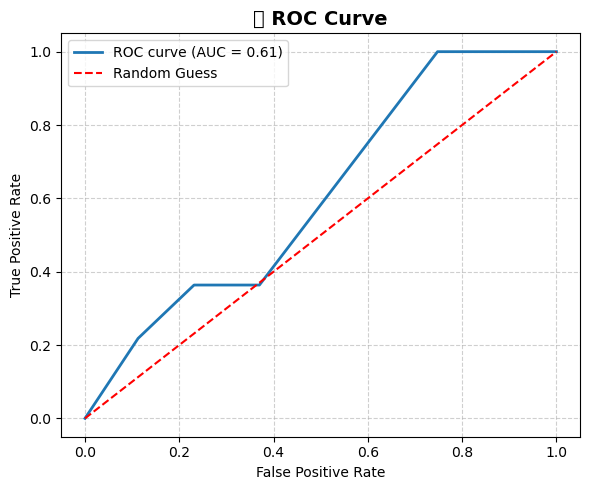

In [22]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", lw=2)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Guess")
plt.title("🎯 ROC Curve", fontsize=14, fontweight='bold')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

/var/folders/bq/_yk5zsn90t11g7lt1yn4v9w40000gn/T/ipykernel_27006/969868837.py:9: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from current font.
  plt.tight_layout()
/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


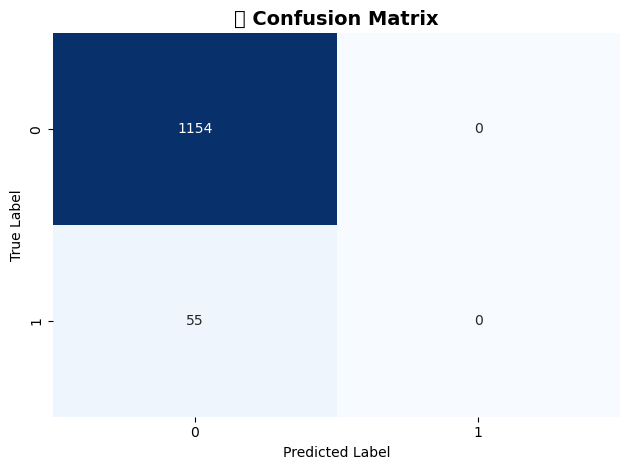

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("🧾 Confusion Matrix", fontsize=14, fontweight='bold')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

/var/folders/bq/_yk5zsn90t11g7lt1yn4v9w40000gn/T/ipykernel_27006/2437442657.py:7: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from current font.
  plt.tight_layout()
/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


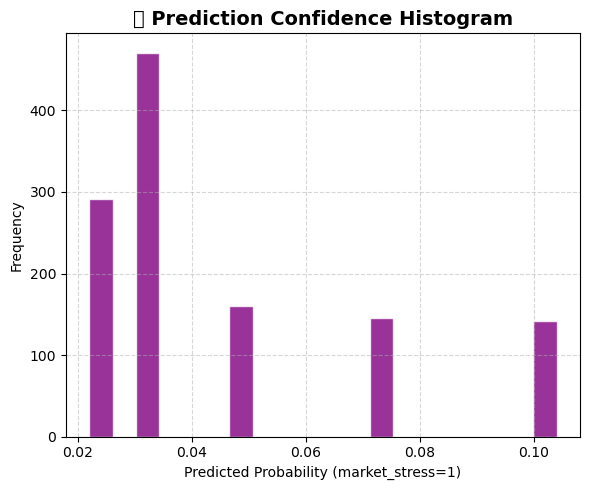

In [26]:
plt.figure(figsize=(6, 5))
plt.hist(y_proba, bins=20, color='purple', edgecolor='white', alpha=0.8)
plt.title("🔮 Prediction Confidence Histogram", fontsize=14, fontweight='bold')
plt.xlabel("Predicted Probability (market_stress=1)")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.draw()
/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from current font.
  fig.canvas.draw()
/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  fig.canvas.draw()
/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  fig.canvas.draw()
/var/folders/bq/_yk5zsn90t11g7lt1yn4v9w40000gn/T/ipykernel_27006/1006463341.py:67: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/var/folders/bq/_yk5zsn90t11g7lt1yn4v9w40000gn/T/ipykernel_27006/1006463341.py:67: UserWarning: Glyph 9989 (\N{WHITE HE

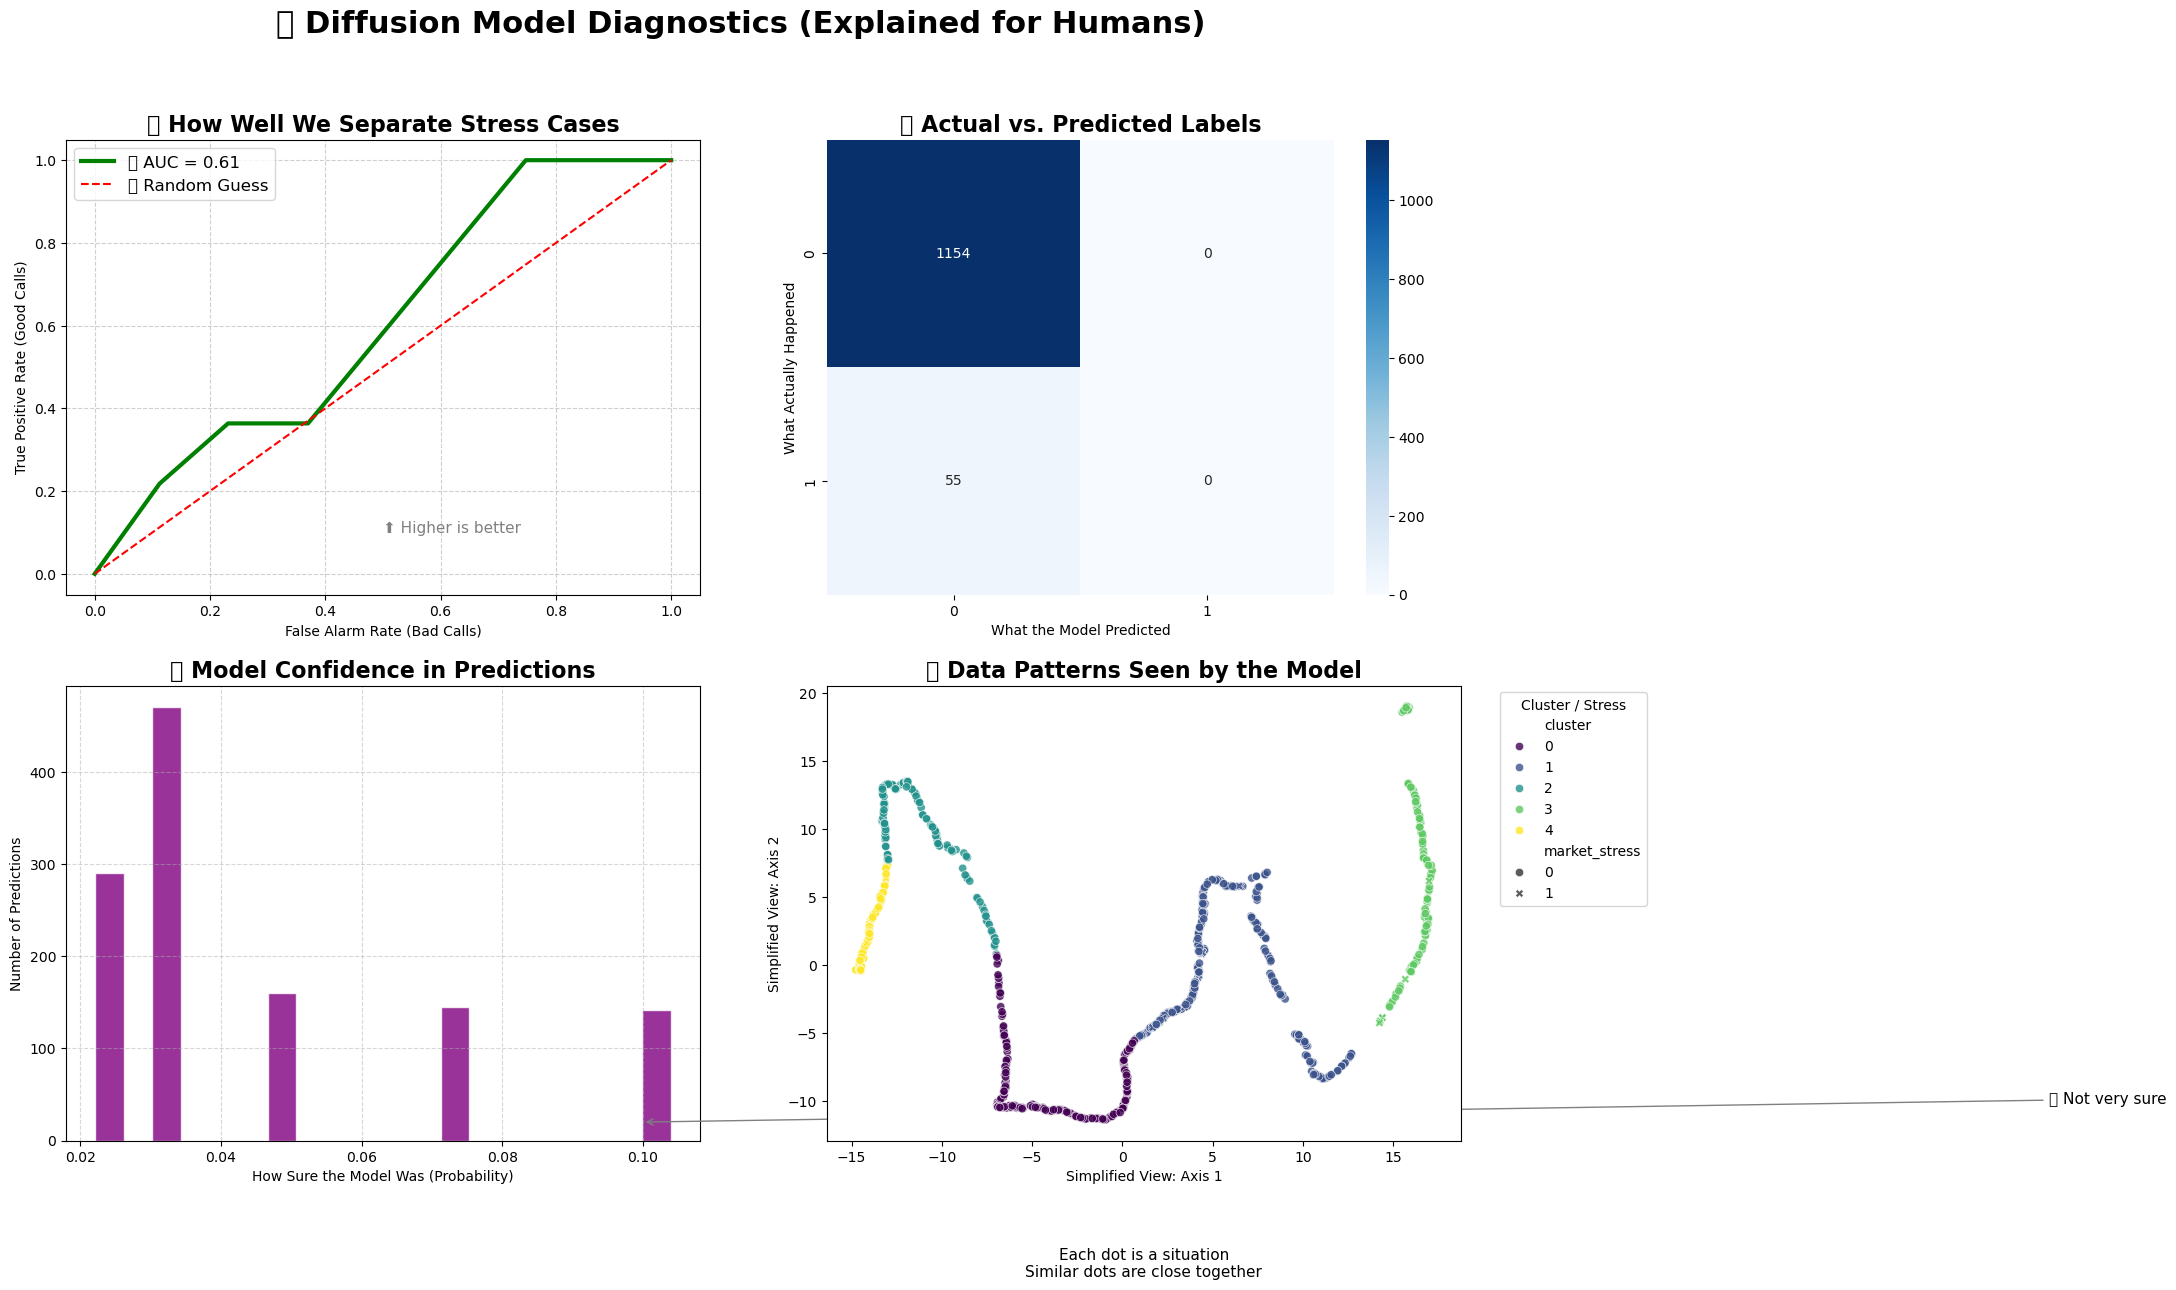

📸 Visualization saved as: pics/diffusion_diagnostics_dashboard_labeled.png


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc, confusion_matrix
import pandas as pd

# ✅ PCA Projection (2D compression for visualization)
pca = PCA(n_components=2, random_state=42)
pca_proj_test = pca.fit_transform(X_test_scaled)
clusters = diffusion_model.predict(X_test_scaled)

# ✅ Prepare DataFrame for Plotting
pca_df = pd.DataFrame(pca_proj_test, columns=["PC1", "PC2"])
pca_df["cluster"] = clusters
pca_df["market_stress"] = y_test.values

# ✅ Set up grid for 4 plots
fig, axes = plt.subplots(2, 2, figsize=(18, 13))
fig.suptitle("🧠 Diffusion Model Diagnostics (Explained for Humans)", fontsize=22, fontweight='bold')

# 🎯 ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
axes[0, 0].plot(fpr, tpr, label=f"👍 AUC = {roc_auc:.2f}", lw=3, color="green")
axes[0, 0].plot([0, 1], [0, 1], 'r--', label="❌ Random Guess")
axes[0, 0].set_title("🎯 How Well We Separate Stress Cases", fontsize=16, fontweight='bold')
axes[0, 0].set_xlabel("False Alarm Rate (Bad Calls)")
axes[0, 0].set_ylabel("True Positive Rate (Good Calls)")
axes[0, 0].legend(fontsize=12)
axes[0, 0].grid(True, linestyle='--', alpha=0.6)
axes[0, 0].text(0.5, 0.1, "⬆️ Higher is better", fontsize=11, color="gray")

# 🧾 Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0, 1])
axes[0, 1].set_title("🧾 Actual vs. Predicted Labels", fontsize=16, fontweight='bold')
axes[0, 1].set_xlabel("What the Model Predicted")
axes[0, 1].set_ylabel("What Actually Happened")
axes[0, 1].text(0.5, -0.4, "Top-left = ✅ Correct guesses", ha='center', fontsize=11, transform=axes[0, 1].transAxes)

# 🔮 Confidence Histogram
axes[1, 0].hist(y_proba, bins=20, color="purple", edgecolor="white", alpha=0.8)
axes[1, 0].set_title("🔮 Model Confidence in Predictions", fontsize=16, fontweight='bold')
axes[1, 0].set_xlabel("How Sure the Model Was (Probability)")
axes[1, 0].set_ylabel("Number of Predictions")
axes[1, 0].grid(True, linestyle='--', alpha=0.5)
axes[1, 0].annotate("👶 Not very sure", xy=(0.1, 20), xytext=(0.3, 40),
                    arrowprops=dict(arrowstyle="->", color="gray"), fontsize=11)
axes[1, 0].annotate("🧠 Very confident", xy=(0.8, 20), xytext=(0.55, 40),
                    arrowprops=dict(arrowstyle="->", color="gray"), fontsize=11)

# 🌌 PCA View of Data
sns.scatterplot(
    data=pca_df,
    x="PC1", y="PC2",
    hue="cluster", style="market_stress",
    palette="viridis", alpha=0.8, ax=axes[1, 1]
)
axes[1, 1].set_title("🌌 Data Patterns Seen by the Model", fontsize=16, fontweight='bold')
axes[1, 1].set_xlabel("Simplified View: Axis 1")
axes[1, 1].set_ylabel("Simplified View: Axis 2")
axes[1, 1].legend(title="Cluster / Stress", bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 1].text(0.5, -0.3, "Each dot is a situation\nSimilar dots are close together", ha='center',
                fontsize=11, transform=axes[1, 1].transAxes)

# ✅ Save and Show
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("pics/diffusion_diagnostics_dashboard_labeled.png", dpi=350)
plt.show()

print("📸 Visualization saved as: pics/diffusion_diagnostics_dashboard_labeled.png")

/var/folders/bq/_yk5zsn90t11g7lt1yn4v9w40000gn/T/ipykernel_27006/4033964466.py:74: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  anim = FuncAnimation(fig, update, frames=len(fpr), init_func=init,
/var/folders/bq/_yk5zsn90t11g7lt1yn4v9w40000gn/T/ipykernel_27006/4033964466.py:74: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from current font.
  anim = FuncAnimation(fig, update, frames=len(fpr), init_func=init,
/var/folders/bq/_yk5zsn90t11g7lt1yn4v9w40000gn/T/ipykernel_27006/4033964466.py:74: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  anim = FuncAnimation(fig, update, frames=len(fpr), init_func=init,
/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128077 (\N{T

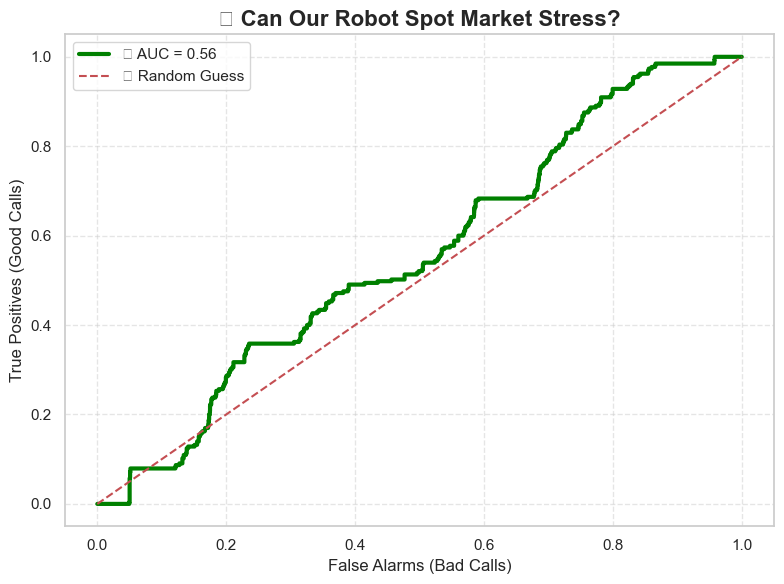

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.metrics import roc_curve, roc_auc_score
import pickle
import pandas as pd
from sklearn.preprocessing import StandardScaler

# ✅ Load Model and Data
model_path = "saved_models/GA-Optimized LR.pkl"
data_path = "../../model_food/data/financial_data_full.csv"

df = pd.read_csv(data_path)
y = df["market_stress"]
X = df.drop(columns=["market_stress"])

# ✅ Keep Only Numeric Columns
X = X.select_dtypes(include=[np.number])

# ✅ Preprocess
scaler = StandardScaler()
# TEMP FIX: Use same features as X_test
X = pd.read_csv(data_path)
y = X["market_stress"]
X = X.drop(columns=["market_stress"])

# Keep only numeric columns
X = X.select_dtypes(include=[np.number])

# Match shape to what model expects (same as X_test)
X = X.iloc[:, :106]  # Assumes first 106 are the ones selected

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# ✅ Preprocess
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ Load Model
with open(model_path, "rb") as f:
    model = pickle.load(f)

# ✅ Predict Probabilities
y_proba = model.predict_proba(X_scaled)[:, 1]
fpr, tpr, _thresholds = roc_curve(y, y_proba)
roc_auc = roc_auc_score(y, y_proba)

# ✅ Set up Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, label=f"👍 AUC = {roc_auc:.2f}", lw=3, color="green")
ax.plot([0, 1], [0, 1], 'r--', label="❌ Random Guess")
ax.set_title("🎯 Can Our Robot Spot Market Stress?", fontsize=16, fontweight='bold')
ax.set_xlabel("False Alarms (Bad Calls)")
ax.set_ylabel("True Positives (Good Calls)")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.5)

# ✅ Animated Dot
dot, = ax.plot([], [], 'o', color='blue', markersize=12)
emoji_text = ax.text(0.05, 0.9, "", fontsize=14, transform=ax.transAxes)

def init():
    dot.set_data([], [])
    emoji_text.set_text("")
    return dot, emoji_text

def update(frame):
    dot.set_data(fpr[frame], tpr[frame])
    emoji = "👶" if frame < len(fpr)//3 else "🧠" if frame > 2*len(fpr)//3 else "🤖"
    emoji_text.set_text(f"Confidence Level: {emoji}")
    return dot, emoji_text

anim = FuncAnimation(fig, update, frames=len(fpr), init_func=init,
                     interval=100, blit=True, repeat=True)

plt.tight_layout()
plt.show()